# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


2025-06-04 11:05:41.959152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749035142.205011      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749035142.281584      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load CSV
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

# Find class from one-hot columns
df['label'] = df[['healthy', 'scab', 'rust', 'multiple_diseases']].idxmax(axis=1)

# Create a full path to image
df['image'] = df['image_id'].apply(lambda x: f"/kaggle/input/plant-pathology-2020-fgvc7/images/{x}.jpg")


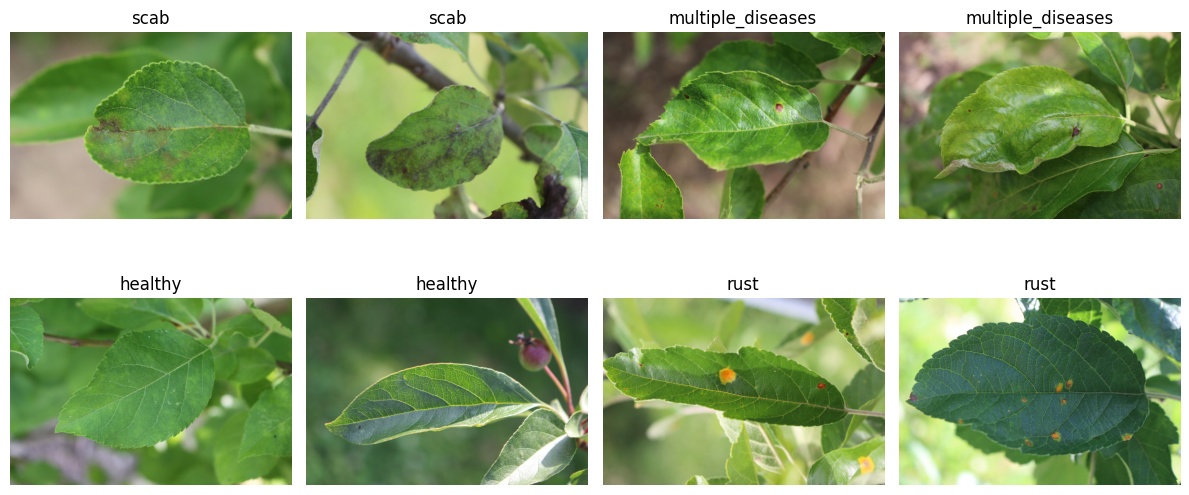

In [3]:
# Classes list
classes = df['label'].unique()

# Plot
plt.figure(figsize=(12, 6))
i = 1
for label in classes:
    sample = df[df['label'] == label].sample(2)
    for row in sample.itertuples():
        img = mpimg.imread(row.image)
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()


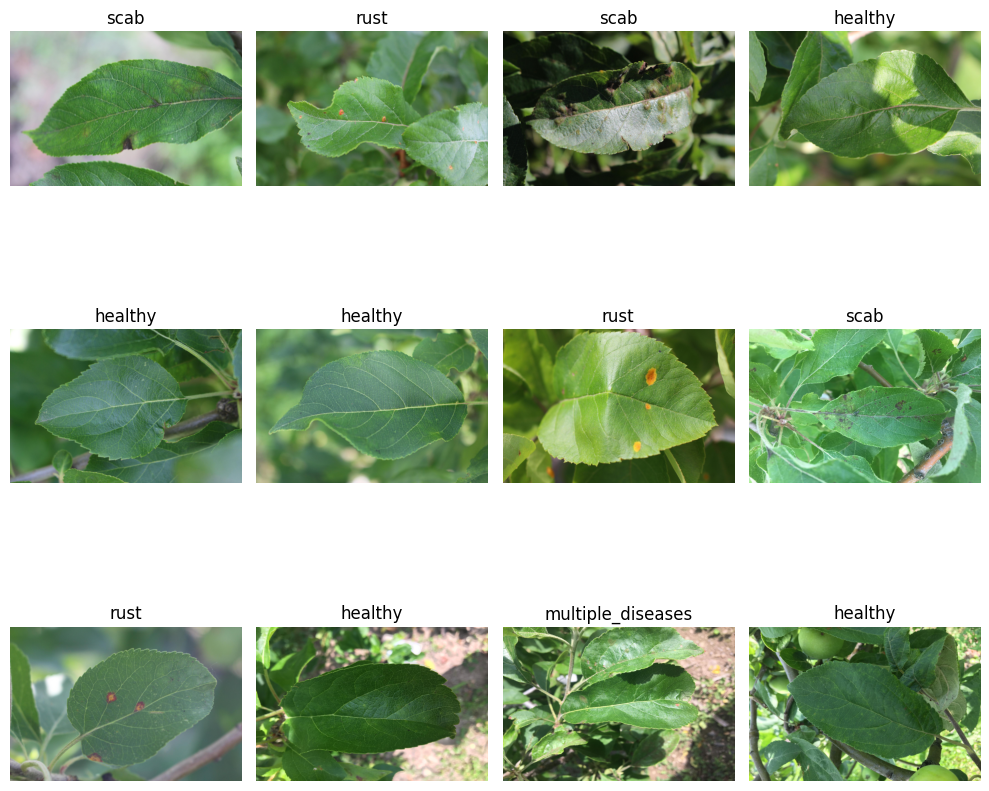

In [4]:
# Randomly select 9 images
sample_df = df.sample(12)

# Plotting
plt.figure(figsize=(10, 10))
for i, row in enumerate(sample_df.itertuples()):
    img = mpimg.imread(row.image)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Data Augmentation

In [5]:
# Data augmentation for training
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    batch_size=32,
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    batch_size=32,
    shuffle=False
)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


# Model Building

In [6]:
# Load MobileNetV2 base
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

2025-06-04 11:06:19.312772: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    # or 'val_accuracy'
    patience=3,            # stop after 3 epochs of no improvement
    restore_best_weights=True
)

# Train model with early stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4041 - loss: 1.3101 - val_accuracy: 0.7115 - val_loss: 0.9141
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6434 - loss: 0.9284 - val_accuracy: 0.7418 - val_loss: 0.7676
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6995 - loss: 0.8026 - val_accuracy: 0.7747 - val_loss: 0.6715
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7500 - loss: 0.7106 - val_accuracy: 0.7885 - val_loss: 0.6366
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7558 - loss: 0.7057 - val_accuracy: 0.8104 - val_loss: 0.5801
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7636 - loss: 0.6959 - val_accuracy: 0.7912 - val_loss: 0.6017
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7802 - loss: 0.5828 - val_accuracy: 0.8049 - val_loss: 0.5744
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7777 - loss: 0.6230 - val_accuracy: 0.8077 - val_loss

# Evaluate the Model

In [8]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8023 - loss: 0.5752
Validation Accuracy: 0.8297
Validation Loss: 0.5009


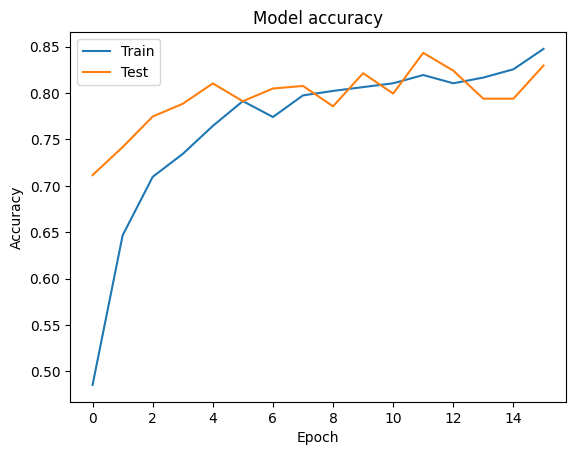

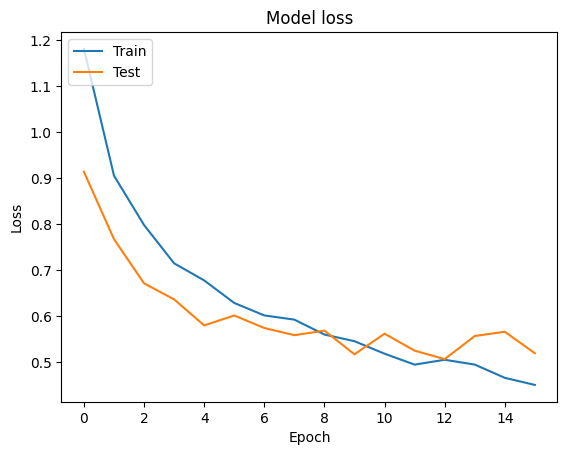

In [9]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
val_generator.reset()
Y_true = val_generator.classes

# Get predictions
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Class indices mapping
labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(Y_true, Y_pred_classes, target_names=labels))


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
                   precision    recall  f1-score   support

          healthy       0.74      0.89      0.80        88
multiple_diseases       0.00      0.00      0.00        20
             rust       0.81      0.91      0.86       116
             scab       0.92      0.81      0.86       140

         accuracy                           0.82       364
        macro avg       0.62      0.65      0.63       364
     weighted avg       0.79      0.82      0.80       364



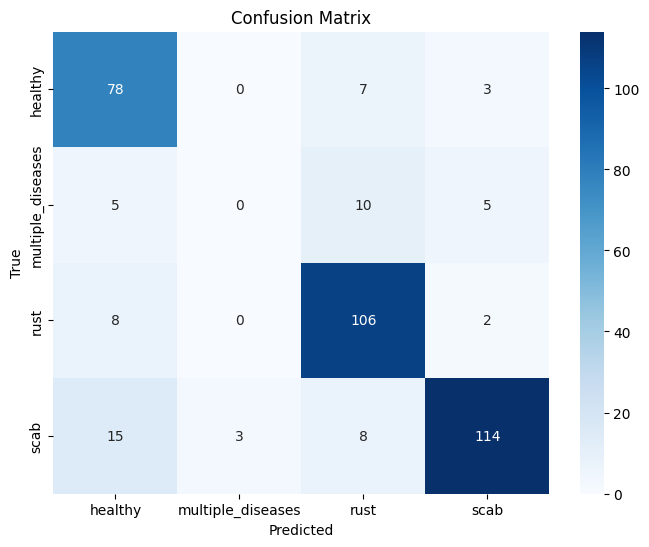

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Prediction on test data

In [12]:
# Load test.csv
test_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")

# Create full image path
test_df['image'] = test_df['image_id'].apply(lambda x: f"/kaggle/input/plant-pathology-2020-fgvc7/images/{x}.jpg")


In [13]:
# Reuse the same rescaling used for training/validation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    shuffle=False
)


Found 1821 validated image filenames.


In [14]:
# Predict probabilities
predictions = model.predict(test_generator)

# Create DataFrame with proper column names
submission = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

# Add image_id column
submission.insert(0, 'image_id', test_df['image_id'])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step


In [15]:
# Save to CSV
submission.to_csv("submission.csv", index=False)